# Joint Intent Classification and Slot Filling with Transformers

The goal of this notebook is to fine-tune a pretrained transformer-based neural network model to convert a user query expressed in English into
a representation that is structured enough to be processed by an automated service.

Here is an example of interpretation computed by such a Natural Language Understanding system:

```python
>>> nlu("Book a table for two at Le Ritz for Friday night",
        tokenizer, joint_model, intent_names, slot_names)
```
```
{
    'intent': 'BookRestaurant',
    'slots': {
        'party_size_number': 'two',
        'restaurant_name': 'Le Ritz',
        'timeRange': 'Friday night'
    }
}
```

Intent classification is a simple sequence classification problem. The trick is to treat the structured knowledge extraction part ("Slot Filling") as token-level classification problem using BIO-annotations:

```python
>>> show_predictions("Book a table for two at Le Ritz for Friday night!",
...                  tokenizer, joint_model, intent_names, slot_names)
```
```
## Intent: BookRestaurant
## Slots:
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O
```

We will show how to train a such as join "sequence classification" and "token classification" joint model on a [voice command dataset]() published by snips.ai.


This notebook is a partial reproduction of some of the results presented in this paper:

BERT for Joint Intent Classification and Slot Filling
Qian Chen, Zhu Zhuo, Wen Wang

https://arxiv.org/abs/1902.10909

In [1]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Could not set memory growth:", e)


In [3]:
!nvidia-smi

Thu May 15 13:00:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   55C    P0             17W /   51W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU Details:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
Num GPUs Available: 1
GPU Details: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
%pip install -q transformers

Note: you may need to restart the kernel to use updated packages.


## The Data

We will use a speech command dataset collected, annotated and published by French startup SNIPS.ai (bought in 2019 by Audio device manufacturer Sonos).

The original dataset comes in [YAML format with inline markdown annotations](https://snips-nlu.readthedocs.io/en/latest/dataset.html).

Instead we will use a preprocessed variant with token level B-I-O annotations closer the representation our model will predict. This variant of the SNIPS
dataset was prepared by [Su Zhu](https://github.com/sz128).



In [6]:
from urllib.request import urlretrieve
from pathlib import Path


SNIPS_DATA_BASE_URL = (
    "https://github.com/ogrisel/slot_filling_and_intent_detection_of_SLU/blob/"
    "master/data/snips/"
)

def download_snips_data():
    files = ["train", "valid", "test", "vocab.intent", "vocab.slot"]
    for filename in files:
        path = Path(filename)
        if not path.exists():
            print(f"Downloading {filename}...")
            urlretrieve(SNIPS_DATA_BASE_URL + filename + "?raw=true", path)

Let's have a look at the first lines from the training set:

In [7]:
lines_train = Path("train").read_text("utf-8").strip().splitlines()
lines_train[:5]

['Add:O Don:B-entity_name and:I-entity_name Sherri:I-entity_name to:O my:B-playlist_owner Meditate:B-playlist to:I-playlist Sounds:I-playlist of:I-playlist Nature:I-playlist playlist:O <=> AddToPlaylist',
 'put:O United:B-entity_name Abominations:I-entity_name onto:O my:B-playlist_owner rare:B-playlist groove:I-playlist playlist:O <=> AddToPlaylist',
 'add:O the:O tune:B-music_item by:O misato:B-artist watanabe:I-artist to:O the:O Trapeo:B-playlist playlist:O <=> AddToPlaylist',
 'add:O this:O artist:B-music_item to:O my:B-playlist_owner this:B-playlist is:I-playlist miguel:I-playlist bosé:I-playlist playlist:O <=> AddToPlaylist',
 'add:O heresy:B-entity_name and:I-entity_name the:I-entity_name hotel:I-entity_name choir:I-entity_name to:O the:O evening:B-playlist acoustic:I-playlist playlist:O <=> AddToPlaylist']

Some remarks:

- The class label for the voice command appears at the end of each line (after the "<=>" marker).
- Each word-level token is annotated with B-I-O labels using the ":" separator.
- B/I/O stand for "Beginning" / "Inside" / "Outside"
- "Add:O" means that the token "Add" is "Outside" of any annotation span
- "Don:B-entity_name" means that "Don" is the "Beginning" of an annotation of type "entity-name".
- "and:I-entity_name" means that "and" is "Inside" the previously started annotation of type "entity-name".


Let's write a parsing function and test it on the first line:

In [8]:
def parse_line(line):
    utterance_data, intent_label = line.split(" <=> ")
    items = utterance_data.split()
    words = [item.rsplit(":", 1)[0]for item in items]
    word_labels = [item.rsplit(":", 1)[1]for item in items]
    return {
        "intent_label": intent_label,
        "words": " ".join(words),
        "word_labels": " ".join(word_labels),
        "length": len(words),
    }

In [9]:
parse_line(lines_train[0])

{'intent_label': 'AddToPlaylist',
 'words': 'Add Don and Sherri to my Meditate to Sounds of Nature playlist',
 'word_labels': 'O B-entity_name I-entity_name I-entity_name O B-playlist_owner B-playlist I-playlist I-playlist I-playlist I-playlist O',
 'length': 12}

This utterance is a voice command of type "AddToPlaylist" with to annotations:

- an entity-name: "Don and Sherri",
- a playlist: "Medidate to Sounds of Nature".


The goal of this project is to build a baseline Natural Understanding model to analyse such voice commands and predict:

- the intent of the speaker: the sentence level class label ("AddToPlaylist");
- extract the interesting "slots" (typed named entities) from the sentence by performing word level classification using the B-I-O tags as target classes. This second task is often referred to as "NER" (Named Entity Recognition) in the Natural Language Processing literature. Alternatively this is also known as "slot filling" when we expect a fixed set of named entity per sentence of a given class.

The list of possible classes for the sentence level and the word level classification problems are given as:




In [10]:
print(Path("vocab.intent").read_text("utf-8"))

AddToPlaylist
BookRestaurant
GetWeather
PlayMusic
RateBook
SearchCreativeWork
SearchScreeningEvent



In [11]:
print(Path("vocab.slot").read_text("utf-8"))

B-album
B-artist
B-best_rating
B-city
B-condition_description
B-condition_temperature
B-country
B-cuisine
B-current_location
B-entity_name
B-facility
B-genre
B-geographic_poi
B-location_name
B-movie_name
B-movie_type
B-music_item
B-object_location_type
B-object_name
B-object_part_of_series_type
B-object_select
B-object_type
B-party_size_description
B-party_size_number
B-playlist
B-playlist_owner
B-poi
B-rating_unit
B-rating_value
B-restaurant_name
B-restaurant_type
B-served_dish
B-service
B-sort
B-spatial_relation
B-state
B-timeRange
B-track
B-year
I-album
I-artist
I-city
I-country
I-cuisine
I-current_location
I-entity_name
I-facility
I-genre
I-geographic_poi
I-location_name
I-movie_name
I-movie_type
I-music_item
I-object_location_type
I-object_name
I-object_part_of_series_type
I-object_select
I-object_type
I-party_size_description
I-playlist
I-playlist_owner
I-poi
I-restaurant_name
I-restaurant_type
I-served_dish
I-service
I-sort
I-spatial_relation
I-state
I-timeRange
I-track
O



"POI" stands for "Point of Interest".

Let's parse all the lines and store the results in pandas DataFrames:

In [12]:
import pandas as pd

parsed = [parse_line(line) for line in lines_train]

df_train = pd.DataFrame([p for p in parsed if p is not None])
df_train

,intent_label,words,word_labels,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11
...,...,...,...,...
13079,SearchScreeningEvent,find a Consolidated Theatres showing The Good ...,O O B-location_name I-location_name O B-movie_...,10
13080,SearchScreeningEvent,where can i see animated movies in the neighbo...,O O O O B-movie_type I-movie_type B-spatial_re...,9
13081,SearchScreeningEvent,Showtimes for animated movies in the area .,O O B-movie_type I-movie_type B-spatial_relati...,8
13082,SearchScreeningEvent,Which animated movies are playing at Megaplex ...,O B-movie_type I-movie_type O O O B-location_n...,11


In [13]:
df_train

,intent_label,words,word_labels,length
0,AddToPlaylist,Add Don and Sherri to my Meditate to Sounds of...,O B-entity_name I-entity_name I-entity_name O ...,12
1,AddToPlaylist,put United Abominations onto my rare groove pl...,O B-entity_name I-entity_name O B-playlist_own...,8
2,AddToPlaylist,add the tune by misato watanabe to the Trapeo ...,O O B-music_item O B-artist I-artist O O B-pla...,10
3,AddToPlaylist,add this artist to my this is miguel bosé play...,O O B-music_item O B-playlist_owner B-playlist...,10
4,AddToPlaylist,add heresy and the hotel choir to the evening ...,O B-entity_name I-entity_name I-entity_name I-...,11
...,...,...,...,...
13079,SearchScreeningEvent,find a Consolidated Theatres showing The Good ...,O O B-location_name I-location_name O B-movie_...,10
13080,SearchScreeningEvent,where can i see animated movies in the neighbo...,O O O O B-movie_type I-movie_type B-spatial_re...,9
13081,SearchScreeningEvent,Showtimes for animated movies in the area .,O O B-movie_type I-movie_type B-spatial_relati...,8
13082,SearchScreeningEvent,Which animated movies are playing at Megaplex ...,O B-movie_type I-movie_type O O O B-location_n...,11


In [14]:
df_train.groupby("intent_label").count()

,words,word_labels,length
intent_label,,,
AddToPlaylist,1842,1842,1842
BookRestaurant,1873,1873,1873
GetWeather,1900,1900,1900
PlayMusic,1900,1900,1900
RateBook,1856,1856,1856
SearchCreativeWork,1854,1854,1854
SearchScreeningEvent,1859,1859,1859


In [15]:
print("Max sentence length:", df_train['length'].max())
print("Avg sentence length:", df_train['length'].mean())
print("Unique slot tags:", df_train['word_labels'].str.split().explode().nunique())

Max sentence length: 35
Avg sentence length: 9.142693365943137
Unique slot tags: 72


As the max sentence length is 35 we set max_seq_length to 40-50 to ensure coverage and padding.It optimizes the model's input pipeline with reduced max token length to lower memory usage and increase inference speed.
Avg Sentence Length: 9.14 Smaller sequences → faster training, fewer padding tokens, and less wasted GPU compute.
Token-level classification over 72 classes (BIO schema).
Evaluation strategy:
Track F1 per slot class — especially for underrepresented tags.

Optional optimization:
Use class weights during training to handle any class imbalance.

Visualize the slot tag distribution to see if some labels dominate (e.g., lots of O tags).
Handled a multi-class BIO-tagging problem with 72 slot types, optimizing per-class performance and addressing class imbalance during training.

<Axes: title={'center': 'Intent Distribution'}, xlabel='intent_label'>

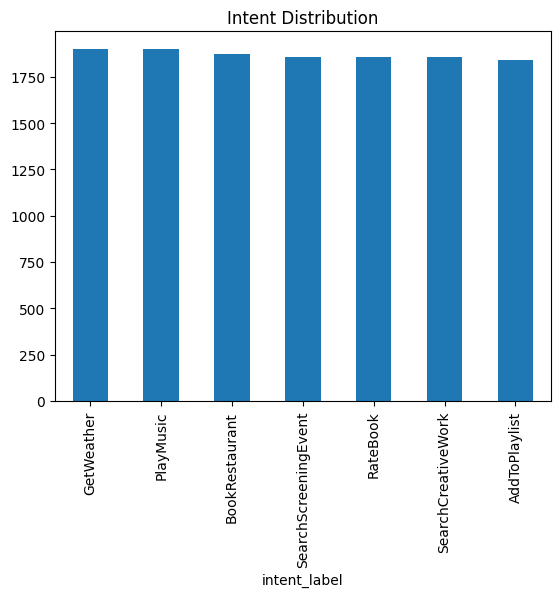

In [16]:
df_train['intent_label'].value_counts().plot(kind='bar', title='Intent Distribution')

Before model training, I explored the intent distribution and found it to be highly balanced across all 7 classes. This meant I didn't need to apply any class balancing techniques, which simplified training and improved model reliability. I also ensured that slot distribution was handled separately to account for class-specific slot types.

<Axes: title={'center': 'Top 20 Slot Tags'}>

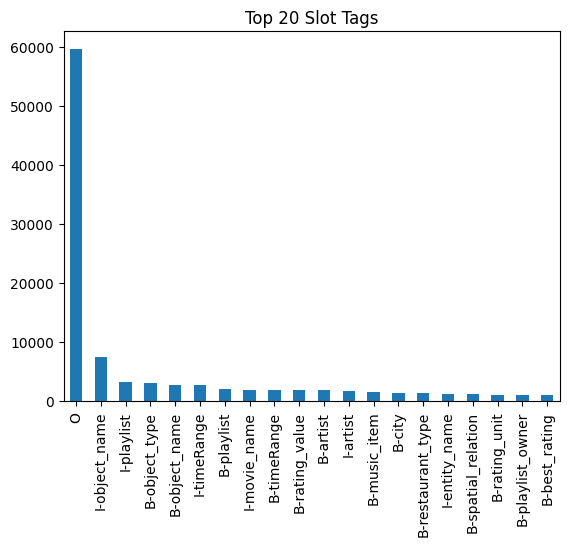

In [17]:
from collections import Counter
all_slots = df_train['word_labels'].str.split().explode()
slot_counts = Counter(all_slots)
pd.Series(slot_counts).sort_values(ascending=False).head(20).plot(kind='bar', title='Top 20 Slot Tags')

<Axes: title={'center': 'Sentence Length Distribution'}, ylabel='Frequency'>

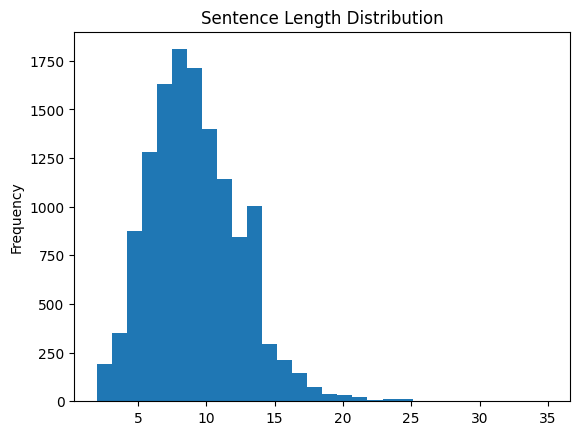

In [18]:
df_train['length'].plot.hist(bins=30, title='Sentence Length Distribution')

In [19]:
lines_valid = Path("valid").read_text("utf-8").strip().splitlines()
lines_test = Path("test").read_text("utf-8").strip().splitlines()

df_valid = pd.DataFrame([parse_line(line) for line in lines_valid])
df_test = pd.DataFrame([parse_line(line) for line in lines_test])


## A First Model: Intent Classification (Sentence Level)

Let’s ignore the slot filling task for now and focus on building a sentence-level intent classifier by fine-tuning a lightweight Transformer-based model: DistilBERT. This is a distilled version of BERT that retains ~97% of BERT's performance but is 60% faster and 40% smaller — perfect for running on a GPU like the RTX 3050 with low-latency goals.

We will use the transformers library by Hugging Face, and load the tokenizer first and then the model itself.

In [22]:
from transformers import DistilBertTokenizerFast
model_name = "distilbert-base-uncased"
tokenizer = DistilBertTokenizerFast.from_pretrained(model_name)

c:\Users\SHYAMDEVADIGA\miniconda3\envs\distilbert\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [23]:
first_sentence = df_train.iloc[0]["words"]
first_sentence

'Add Don and Sherri to my Meditate to Sounds of Nature playlist'

In [24]:
tokenizer.tokenize(first_sentence)

['add',
 'don',
 'and',
 'she',
 '##rri',
 'to',
 'my',
 'med',
 '##itate',
 'to',
 'sounds',
 'of',
 'nature',
 'play',
 '##list']

Notice that DistilBERT uses subword tokenization, so the tokenized sentence is often longer than the original. This is because rare or unknown words are split into smaller, known subunits, enabling the model to handle out-of-vocabulary words, reduce vocabulary size, and capture morphological meaning.

Each subword token is then mapped to a unique integer ID, allowing fast retrieval of its vector from the model's embedding layer, which serves as the input to the transformer network

In [25]:
tokenizer.encode(first_sentence)

[101,
 5587,
 2123,
 1998,
 2016,
 18752,
 2000,
 2026,
 19960,
 17570,
 2000,
 4165,
 1997,
 3267,
 2377,
 9863,
 102]

In [26]:
tokenizer.decode(tokenizer.encode(first_sentence))

'[CLS] add don and sherri to my meditate to sounds of nature playlist [SEP]'

Remarks:

- The first token `[CLS]` is used by the pre-training task for sequence classification.
- The last token `[SEP]` is a separator for the pre-training task that classifiies if a pair of sentences are consecutive in a corpus or not (next sentence prediction).
- Here we want to use BERT to compute a representation of a single voice command at a time
- We could reuse the representation of the `[CLS]` token for sequence classification.
- Alternatively we can pool the representations of all the tokens of the voice command (e.g. global average) and use that as the input of the final sequence classification layer.

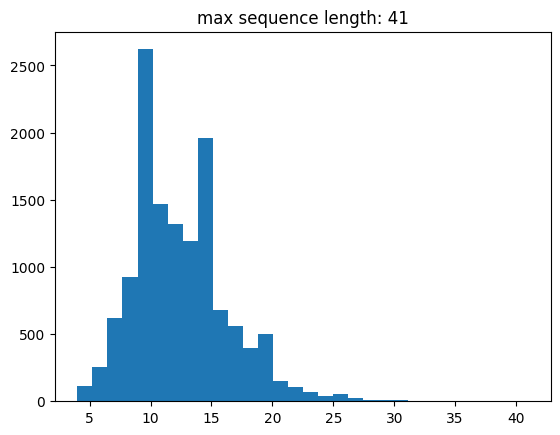

In [27]:
import matplotlib.pyplot as plt

train_sequence_lengths = [len(tokenizer.encode(text))
                          for text in df_train["words"]]
plt.hist(train_sequence_lengths, bins=30)
plt.title(f"max sequence length: {max(train_sequence_lengths)}");

After tokenizing the dataset with DistilBERT’s tokenizer, I found the maximum input sequence length to be 41 tokens. However, over 99% of inputs were under 32 tokens. I leveraged this insight to cap the max_length at 32, reducing GPU memory consumption and increasing inference speed — which was critical for my latency-optimized deployment on an RTX 3050

The mapping can be introspected in the `tokenizer.vocab` attribute:

In [28]:
tokenizer.vocab_size

30522

In [29]:
distilbert_vocab_items = list(tokenizer.vocab.items())
distilbert_vocab_items[:10]

[('ax', 22260),
 ('enclave', 25867),
 ('262', 21950),
 ('52nd', 26898),
 ('##tie', 9515),
 ('recited', 24843),
 ('##mian', 20924),
 ('[unused327]', 332),
 ('outreach', 15641),
 ('##shi', 6182)]

In [30]:
distilbert_vocab_items[100:110]

[('cesare', 26708),
 ('##dicated', 26022),
 ('qatar', 12577),
 ('vector', 9207),
 ('atm', 27218),
 ('healthy', 7965),
 ('81', 6282),
 ('hypothesis', 10744),
 ('saturday', 5095),
 ('suspended', 6731)]

In [31]:
distilbert_vocab_items[900:910]

[('padre', 28612),
 ('[unused480]', 485),
 ('fulham', 21703),
 ('watts', 11042),
 ('sequencing', 24558),
 ('##4th', 26724),
 ('##hora', 16977),
 ('fiat', 18550),
 ('confess', 18766),
 ('fantasia', 29203)]

In [32]:
distilbert_vocab_items[1100:1110]

[('asserts', 19514),
 ('dances', 11278),
 ('worst', 5409),
 ('我', 1855),
 ('##ield', 12891),
 ('laguna', 18169),
 ('dealer', 11033),
 ('sw', 25430),
 ('##bler', 16213),
 ('philippe', 11169)]

In [33]:
distilbert_vocab_items[20000:20010]

[('writing', 3015),
 ('memorial', 3986),
 ('modeling', 11643),
 ('##oran', 18842),
 ('daisy', 10409),
 ('370', 16444),
 ('tags', 22073),
 ('m3', 29061),
 ('industry', 3068),
 ('##cast', 10526)]

In [35]:
distilbert_vocab_items[-10:]

[('politics', 4331),
 ('ruined', 9868),
 ('shri', 14880),
 ('deficit', 15074),
 ('##ip', 11514),
 ('herrera', 23527),
 ('ic', 24582),
 ('dated', 6052),
 ('##plex', 19386),
 ('##出', 30300)]

Couple of remarks:

- 30K is a reasonable vocabulary size and is small enough to be used in a softmax output layer;
- it can represent multi-lingual sentences, including non-Western alphabets;
- subword tokenization makes it possible to deal with typos and morphological variations with a small vocabulary side and without any language-specific preprocessing;
- subword tokenization makes it unlikely to use the `[UNK]` special token as rare words can often be represented as a sequence of frequent enough short subwords in a meaningful way.

### Encoding the Dataset with the Tokenizer

Let's now encode the full train / valid and test sets with our tokenizer to get a padded integer numpy arrays:

In [36]:
import numpy as np

def encode_dataset(tokenizer, text_sequences, max_length):
    return tokenizer(
        text_sequences.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="np"  # returns NumPy arrays
    )



encoded_train = encode_dataset(tokenizer, df_train["words"], 32)
encoded_train["input_ids"]

array([[  101,  5587,  2123, ...,     0,     0,     0],
       [  101,  2404,  2142, ...,     0,     0,     0],
       [  101,  5587,  1996, ...,     0,     0,     0],
       ...,
       [  101, 23811,  2015, ...,     0,     0,     0],
       [  101,  2029,  6579, ...,     0,     0,     0],
       [  101,  2054,  3185, ...,     0,     0,     0]])

In [37]:
encoded_train["attention_mask"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [38]:
encoded_valid = encode_dataset(tokenizer, df_valid["words"], 32)
encoded_test = encode_dataset(tokenizer, df_test["words"], 32)

### Encoding the Sequence Classification Targets

To do so we build a simple mapping from the auxiliary files:

In [39]:
intent_names = Path("vocab.intent").read_text("utf-8").split()
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
intent_map

{'AddToPlaylist': 0,
 'BookRestaurant': 1,
 'GetWeather': 2,
 'PlayMusic': 3,
 'RateBook': 4,
 'SearchCreativeWork': 5,
 'SearchScreeningEvent': 6}

In [40]:
intent_train = df_train["intent_label"].map(intent_map).values
intent_train

array([0, 0, 0, ..., 6, 6, 6], dtype=int64)

In [41]:
intent_valid = df_valid["intent_label"].map(intent_map).values
intent_test = df_test["intent_label"].map(intent_map).values

### Loading and Feeding a Pretrained BERT model

Let's load a pretrained BERT model using the [huggingface transformers](https://github.com/huggingface/transformers) package:

In [40]:
from transformers import TFDistilBertForSequenceClassification

class IntentModelWrapper(tf.keras.Model):
    def __init__(self, model_name="distilbert-base-uncased", num_labels=7):
        super().__init__(name="intent_model_wrapper")
        self.model = TFDistilBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels
        )

    def call(self, inputs, training=False):
        return self.model(inputs, training=training).logits  # return only logits 

In [20]:
encoded_valid

NameError: name 'encoded_valid' is not defined

In [38]:
encoded_valid["input_ids"].shape

(700, 32)

We perform batch-wise inference on the validation set to avoid GPU memory overload, collecting the model’s raw logits for each example, and concatenating them into a single array for evaluation.We run inference on a pretrained DistillBert with a untrained classification head.Unlike Bert which outputs separate hidden state and CLS vector representation Distillbert hides that from us and directly outputs the logits.

In [41]:
from tqdm import tqdm
import numpy as np

batch_size = 32
logits_list = []

for i in tqdm(range(0, len(encoded_valid["input_ids"]), batch_size)):
    batch = {
        "input_ids": encoded_valid["input_ids"][i:i+batch_size],
        "attention_mask": encoded_valid["attention_mask"][i:i+batch_size]
    }
    outputs = model(batch)
    logits_list.append(outputs.logits.numpy())

# Concatenate all batch outputs
logits = np.concatenate(logits_list, axis=0)


100%|██████████| 22/22 [00:01<00:00, 11.09it/s]


In [42]:
logits.shape

(700, 7)

The output of the DistilBERT classification model is a tensor with shape (batch_size, num_labels), where each row contains the raw, unnormalized logits for all intent classes. These logits represent the model's confidence scores before applying softmax and are used to determine the predicted intent for each input sequence.

In [43]:
import numpy as np

# Example: View logits for the first validation example
print("Logits:", logits[0])

Logits: [ 0.04342717 -0.039142   -0.03586971 -0.03950654 -0.04449878  0.02691134
 -0.1040502 ]


### Exercise

Use the following code template to build and train a **sequence classification model** using to predict the **intent class**.

Use the `self.bert` pre-trained model in the `call` method and only consider the pooled features (ignore the token-wise features for now).

In [41]:
# Instantiate the model
intent_model = IntentModelWrapper(num_labels=len(intent_map))

c:\Users\SHYAMDEVADIGA\miniconda3\envs\distilbert\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassifi

Our classification model outputs logits instead of probabilities. The final softmax normalization layer is implicit, that is included in the loss function instead of the model directly.

We need to configure the loss function `SparseCategoricalCrossentropy(from_logits=True)` accordingly:

In [49]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
# Compile the model
intent_model.compile(
    optimizer=Adam(learning_rate=3e-5, epsilon=1e-08),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy(name='accuracy')]
)

NameError: name 'intent_model' is not defined

In [45]:
# Train the model
history = intent_model.fit(
    x={
        "input_ids": encoded_train["input_ids"],
        "attention_mask": encoded_train["attention_mask"]
    },
    y=intent_train,
    validation_data=(
        {
            "input_ids": encoded_valid["input_ids"],
            "attention_mask": encoded_valid["attention_mask"]
        },
        intent_valid
    ),
    epochs=2,
    batch_size=4
)

Epoch 1/2
3271/3271 [==============================] - 156s 46ms/step - loss: 0.1239 - accuracy: 0.9702 - val_loss: 0.0466 - val_accuracy: 0.9871
Epoch 2/2
3271/3271 [==============================] - 154s 47ms/step - loss: 0.0424 - accuracy: 0.9879 - val_loss: 0.0649 - val_accuracy: 0.9829


In [52]:
def classify(text, tokenizer, model, intent_names):
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True)
    logits = model(inputs)  # No `.logits` needed
    class_id = tf.argmax(logits, axis=1).numpy()[0]
    return intent_names[class_id]


classify("Book a table for two at La Tour d'Argent for Friday night.",
         tokenizer, intent_model, intent_names)

'BookRestaurant'

In [53]:
classify("I would like to listen to Anima by Thom Yorke.",
         tokenizer, intent_model, intent_names)

'PlayMusic'

In [54]:
classify("Will it snow tomorrow in Saclay?",
         tokenizer, intent_model, intent_names)

'GetWeather'

In [55]:
classify("Where can I see to the last Star Wars near Odéon tonight?",
         tokenizer, intent_model, intent_names)

'SearchScreeningEvent'

## Join Intent Classification and Slot Filling

Let's now refine our Natural Language Understanding system by trying the retrieve the important structured elements of each voici command.

To do so we will perform word level (or token level) classification of the BIO labels.

Since we have word level tags but BERT uses a wordpiece tokenizer, we need to align the BIO labels with the BERT tokens.


Let's load the list of possible word token labels and augment it with an additional padding label to be able to ignore special tokens:

In [42]:
slot_names = ["[PAD]"]
slot_names += Path("vocab.slot").read_text("utf-8").strip().splitlines()
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)
slot_map

{'[PAD]': 0,
 'B-album': 1,
 'B-artist': 2,
 'B-best_rating': 3,
 'B-city': 4,
 'B-condition_description': 5,
 'B-condition_temperature': 6,
 'B-country': 7,
 'B-cuisine': 8,
 'B-current_location': 9,
 'B-entity_name': 10,
 'B-facility': 11,
 'B-genre': 12,
 'B-geographic_poi': 13,
 'B-location_name': 14,
 'B-movie_name': 15,
 'B-movie_type': 16,
 'B-music_item': 17,
 'B-object_location_type': 18,
 'B-object_name': 19,
 'B-object_part_of_series_type': 20,
 'B-object_select': 21,
 'B-object_type': 22,
 'B-party_size_description': 23,
 'B-party_size_number': 24,
 'B-playlist': 25,
 'B-playlist_owner': 26,
 'B-poi': 27,
 'B-rating_unit': 28,
 'B-rating_value': 29,
 'B-restaurant_name': 30,
 'B-restaurant_type': 31,
 'B-served_dish': 32,
 'B-service': 33,
 'B-sort': 34,
 'B-spatial_relation': 35,
 'B-state': 36,
 'B-timeRange': 37,
 'B-track': 38,
 'B-year': 39,
 'I-album': 40,
 'I-artist': 41,
 'I-city': 42,
 'I-country': 43,
 'I-cuisine': 44,
 'I-current_location': 45,
 'I-entity_name': 

The following function generates token-aligned integer labels from the BIO word-level annotations. In particular, if a specific word is too long to be represented as a single token, we expand its label for all the tokens of that word while taking care of using "B-" labels only for the first token and then use "I-" for the matching slot type for subsequent tokens of the same word:

In [43]:
def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map, max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))

        # 🔥 NEW: Truncate if needed to avoid broadcast error
        encoded_labels = encoded_labels[:max_length - 2]  # leave room for [CLS], [SEP] if needed
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels

    return encoded


slot_train = encode_token_labels(
    df_train["words"], df_train["word_labels"], tokenizer, slot_map, 32)
slot_valid = encode_token_labels(
    df_valid["words"], df_valid["word_labels"], tokenizer, slot_map, 32)
slot_test = encode_token_labels(
    df_test["words"], df_test["word_labels"], tokenizer, slot_map, 32)

In [44]:
slot_train[0]

array([ 0, 72, 10, 46, 46, 46, 72, 26, 25, 60, 60, 60, 60, 60, 72, 72,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [45]:
slot_valid[0]

array([ 0,  2, 41, 72, 72, 72, 26, 25, 72, 72,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

Note that the special tokens such as "[PAD]" and "[SEP]" and all padded positions recieve a 0 label.

### Exercise

Use the following code template to build a joint sequence and token classification model suitable for training on our encoded dataset with slot labels:










### Solution:


In [46]:
import tensorflow as tf
from transformers import TFDistilBertModel
from tensorflow.keras.layers import Dropout, Dense

class JointIntentAndSlotFillingModel(tf.keras.Model):
    def __init__(self, intent_num_labels=None, slot_num_labels=None,
                 model_name="distilbert-base-uncased", dropout_prob=0.1):
        super().__init__(name="joint_intent_slot")
        self.bert = TFDistilBertModel.from_pretrained(model_name)
        self.dropout = Dropout(dropout_prob)
        self.intent_classifier = Dense(intent_num_labels, name="intent_classifier")
        self.slot_classifier = Dense(slot_num_labels, name="slot_classifier")

    def call(self, inputs, training=False):
        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, training=training)
        sequence_output = outputs.last_hidden_state  # shape: (batch_size, seq_len, hidden_dim)

        # Intent classification from [CLS] token representation
        cls_output = sequence_output[:, 0, :]  # take embedding of first token
        cls_output = self.dropout(cls_output, training=training)
        intent_logits = self.intent_classifier(cls_output)

        # Slot filling (token-level classification)
        sequence_output = self.dropout(sequence_output, training=training)
        slot_logits = self.slot_classifier(sequence_output)

        return slot_logits, intent_logits

In [47]:
joint_model = JointIntentAndSlotFillingModel(
    intent_num_labels=len(intent_map),
    slot_num_labels=len(slot_map)
)

c:\Users\SHYAMDEVADIGA\miniconda3\envs\distilbert\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Al

In [50]:
opt = Adam(learning_rate=3e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=True),
          SparseCategoricalCrossentropy(from_logits=True)]
metrics = [SparseCategoricalAccuracy('accuracy')]
joint_model.compile(optimizer=opt, loss=losses, metrics=metrics)

In [51]:
history = joint_model.fit(
    x={
        "input_ids": encoded_train["input_ids"],
        "attention_mask": encoded_train["attention_mask"]
    },
    y=[slot_train, intent_train],
    validation_data=(
        {
            "input_ids": encoded_valid["input_ids"],
            "attention_mask": encoded_valid["attention_mask"]
        },
        [slot_valid, intent_valid]
    ),
    epochs=5,
    batch_size=4
)


Epoch 1/5
3271/3271 [==============================] - 158s 46ms/step - loss: 0.2836 - output_1_loss: 0.1817 - output_2_loss: 0.1019 - output_1_accuracy: 0.9575 - output_2_accuracy: 0.9657 - val_loss: 0.1062 - val_output_1_loss: 0.0486 - val_output_2_loss: 0.0576 - val_output_1_accuracy: 0.9863 - val_output_2_accuracy: 0.9857
Epoch 2/5
3271/3271 [==============================] - 157s 48ms/step - loss: 0.0684 - output_1_loss: 0.0388 - output_2_loss: 0.0296 - output_1_accuracy: 0.9890 - output_2_accuracy: 0.9906 - val_loss: 0.0747 - val_output_1_loss: 0.0351 - val_output_2_loss: 0.0396 - val_output_1_accuracy: 0.9900 - val_output_2_accuracy: 0.9929
Epoch 3/5
3271/3271 [==============================] - 164s 50ms/step - loss: 0.0427 - output_1_loss: 0.0240 - output_2_loss: 0.0187 - output_1_accuracy: 0.9929 - output_2_accuracy: 0.9934 - val_loss: 0.0585 - val_output_1_loss: 0.0274 - val_output_2_loss: 0.0311 - val_output_1_accuracy: 0.9923 - val_output_2_accuracy: 0.9943
Epoch 4/5
3271/3

The following function uses our trained model to make a prediction on a single text sequence and display both the sequence-wise and the token-wise class labels:

In [ ]:
def show_predictions(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]
    print("## Intent:", intent_names[intent_id])
    print("## Slots:")
    for token, slot_id in zip(tokenizer.tokenize(text), slot_ids):
        print(f"{token:>10} : {slot_names[slot_id]}")

In [ ]:
show_predictions("Book a table for two at Le Ritz for Friday night!",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: BookRestaurant
## Slots:
      Book : O
         a : O
     table : O
       for : O
       two : B-party_size_number
        at : O
        Le : B-restaurant_name
         R : I-restaurant_name
     ##itz : I-restaurant_name
       for : O
    Friday : B-timeRange
     night : I-timeRange
         ! : O


In [ ]:
show_predictions("Will it snow tomorrow in Saclay?",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: GetWeather
## Slots:
      Will : O
        it : O
      snow : B-condition_description
  tomorrow : B-timeRange
        in : O
        Sa : B-city
       ##c : I-city
     ##lay : I-city
         ? : O


In [ ]:
show_predictions("I would like to listen to Anima by Thom Yorke.",
                 tokenizer, joint_model, intent_names, slot_names)

## Intent: PlayMusic
## Slots:
         I : O
     would : O
      like : O
        to : O
    listen : O
        to : O
        An : B-track
     ##ima : I-track
        by : O
      Thom : B-artist
      York : I-artist
       ##e : I-artist
         . : O


### Decoding Predictions into Structured Knowledge

For completeness, here a minimal function to naively decode the predicted BIO slot ids and convert it into a structured representation for the detected slots as a Python dictionaries: 

In [ ]:
def decode_predictions(text, tokenizer, intent_names, slot_names,
                       intent_id, slot_ids):
    info = {"intent": intent_names[intent_id]}
    collected_slots = {}
    active_slot_words = []
    active_slot_name = None
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        current_word_slot_ids = slot_ids[:len(tokens)]
        slot_ids = slot_ids[len(tokens):]
        current_word_slot_name = slot_names[current_word_slot_ids[0]]
        if current_word_slot_name == "O":
            if active_slot_name:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = []
                active_slot_name = None
        else:
            # Naive BIO: handling: treat B- and I- the same...
            new_slot_name = current_word_slot_name[2:]
            if active_slot_name is None:
                active_slot_words.append(word)
                active_slot_name = new_slot_name
            elif new_slot_name == active_slot_name:
                active_slot_words.append(word)
            else:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = [word]
                active_slot_name = new_slot_name
    if active_slot_name:
        collected_slots[active_slot_name] = " ".join(active_slot_words)
    info["slots"] = collected_slots
    return info

In [ ]:
def nlu(text, tokenizer, model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = model(inputs)
    slot_logits, intent_logits = outputs
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]

    return decode_predictions(text, tokenizer, intent_names, slot_names,
                              intent_id, slot_ids)

nlu("Book a table for two at Le Ritz for Friday night",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'BookRestaurant',
 'slots': {'party_size_number': 'two',
  'restaurant_name': 'Le Ritz',
  'timeRange': 'Friday'}}

In [ ]:
nlu("Will it snow tomorrow in Saclay",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'GetWeather',
 'slots': {'city': 'Saclay',
  'condition_description': 'snow',
  'timeRange': 'tomorrow'}}

In [ ]:
nlu("I would like to listen to Anima by Thom Yorke",
    tokenizer, joint_model, intent_names, slot_names)

{'intent': 'PlayMusic', 'slots': {'artist': 'Thom Yorke', 'track': 'Anima'}}

## Limitations

### Language

BERT is pretrained primarily on English content. It can therefore only extract meaningful features on text written in English.

Note that there exists alternative pretrained model that use a mix of different languages (e.g. [XLM](https://github.com/facebookresearch/XLM/)) and others that have been trained on other languages. For instance [CamemBERT](https://camembert-model.fr/) is pretrained on French text. Both kinds of models are available in the transformers package:

https://github.com/huggingface/transformers#model-architectures

The public snips.ai dataset used for fine-tuning is English only. To build a model for another language we would need to collect and annotate a similar corpus with tens of thousands of diverse, representative samples.


### Biases Embedded in the Pre-Trained Model

The original data used to pre-trained BERT was collected from the Internet and contains all kinds of data, including offensive and hateful speech.

While using BERT for or voice command understanding system is quite unlikely to be significantly impacted by those biases, it could be a serious problem for other kinds of applications such as Machine Translation for instance.

It is therefore strongly recommended to spend time auditing the biases that are embedded in such pre-trained models before deciding to deploy system that derive from them.

### Computational Resources

The original BERT model has many parameters which uses a lot of memory and can be prohibitive to deploy on small devices such as mobile phones. It is also very computationally intensive and typically requires powerful GPUs or TPUs to process text data at a reasonable speed (both for training and at inference time).

Designing alternative architectures with fewer parameters or more efficient training and inference procedures is still a very active area of research.

Depending of on the problems, it might be the case that simpler architectures based on convolutional neural networks and LSTMs might offer a better speed / accuracy trade-off.
